# Part 1

# jwl2183 Project (group 19)

## Programatically downloading

In [99]:
import os
import re
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# Define the base URL
base_url = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Directories for downloaded files
os.makedirs("data/yellow_taxi", exist_ok=True)
os.makedirs("data/hvfhv", exist_ok=True)
os.makedirs("data", exist_ok=True)  # Ensure data directory exists for taxi_zone_lookup.csv

# Define date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 8, 31)

# Function to extract and download Parquet files
def download_parquet_files(base_url, ride_type, folder_name):
    """
    Downloads Parquet files for the specified ride type within a given date range.

    Args:
        base_url (str): The base URL of the NYC TLC trip record data page.
        ride_type (str): The type of ride data to download ('yellow_taxi' or 'hvfhv').
        folder_name (str): The folder where the Parquet files will be saved.

    """
    response = requests.get(base_url)
    if response.status_code != 200:
        print(f"Failed to fetch webpage for {ride_type}. Status code: {response.status_code}")
        return

    soup = BeautifulSoup(response.text, "html.parser")
    
    # Regular expressions for Yellow Taxi and HVFHV files
    if ride_type == "yellow_taxi":
        pattern = r".*yellow_tripdata_\d{4}-\d{2}\.parquet$"
    elif ride_type == "hvfhv":
        pattern = r".*fhvhv_tripdata_\d{4}-\d{2}\.parquet$"
    else:
        raise ValueError("Invalid ride type. Choose 'yellow_taxi' or 'hvfhv'.")

    # Find all matching file links
    links = soup.find_all("a", href=True)
    parquet_links = [link["href"] for link in links if re.match(pattern, link["href"])]

    # Filter links by date range
    filtered_links = []
    for link in parquet_links:
        match = re.search(r"_(\d{4}-\d{2})\.parquet$", link)
        if match:
            file_date = datetime.strptime(match.group(1), "%Y-%m")
            if start_date <= file_date <= end_date:
                filtered_links.append(link)

    # Download files
    for link in filtered_links:
        file_name = link.split("/")[-1]
        file_path = os.path.join(folder_name, file_name)
        
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            try:
                with requests.get(link, stream=True) as r:
                    if r.status_code == 200:
                        with open(file_path, "wb") as f:
                            for chunk in r.iter_content(chunk_size=8192):
                                f.write(chunk)
                    else:
                        print(f"Failed to download {file_name}. Status code: {r.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {e}")
        else:
            print(f"{file_name} already exists.")

# Function to download the taxi_zone_lookup.csv file
def download_taxi_zone_lookup(base_url):
    """
    Downloads the taxi_zone_lookup.csv file from the NYC TLC website.

    """
    response = requests.get(base_url)
    if response.status_code != 200:
        print(f"Failed to fetch webpage for taxi zone lookup. Status code: {response.status_code}")
        return

    soup = BeautifulSoup(response.text, "html.parser")

    # Locate the taxi_zone_lookup.csv link
    csv_link = None
    for link in soup.find_all("a", href=True):
        if "taxi_zone_lookup.csv" in link["href"]:
            csv_link = link["href"]
            break

    if csv_link:
        # Handle relative URLs
        if not csv_link.startswith("http"):
            csv_link = f"https://www.nyc.gov{csv_link}"

        file_path = "data/taxi_zone_lookup.csv"
        print(f"Downloading taxi_zone_lookup.csv to {file_path}...")
        
        try:
            with requests.get(csv_link, stream=True) as r:
                if r.status_code == 200:
                    with open(file_path, "wb") as f:
                        for chunk in r.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print(f"taxi_zone_lookup.csv downloaded successfully!")
                else:
                    print(f"Failed to download taxi_zone_lookup.csv. Status code: {r.status_code}")
        except Exception as e:
            print(f"An error occurred while downloading taxi_zone_lookup.csv: {e}")
    else:
        print("taxi_zone_lookup.csv link not found.")

# Download Yellow Taxi Trip Records
download_parquet_files(base_url, "yellow_taxi", "data/yellow_taxi")

# Download High Volume For-Hire Vehicle Trip Records
download_parquet_files(base_url, "hvfhv", "data/hvfhv")

# Download the taxi_zone_lookup.csv file
download_taxi_zone_lookup(base_url)


yellow_tripdata_2024-04.parquet already exists.
yellow_tripdata_2024-05.parquet already exists.
yellow_tripdata_2024-06.parquet already exists.
yellow_tripdata_2024-07.parquet already exists.
yellow_tripdata_2024-08.parquet already exists.
yellow_tripdata_2023-01.parquet already exists.
yellow_tripdata_2023-02.parquet already exists.
yellow_tripdata_2023-03.parquet already exists.
yellow_tripdata_2023-04.parquet already exists.
yellow_tripdata_2023-06.parquet already exists.
yellow_tripdata_2023-12.parquet already exists.
yellow_tripdata_2022-01.parquet already exists.
yellow_tripdata_2022-02.parquet already exists.
yellow_tripdata_2022-03.parquet already exists.
yellow_tripdata_2022-04.parquet already exists.
yellow_tripdata_2022-05.parquet already exists.
yellow_tripdata_2022-06.parquet already exists.
yellow_tripdata_2022-07.parquet already exists.
yellow_tripdata_2022-08.parquet already exists.
yellow_tripdata_2022-09.parquet already exists.
yellow_tripdata_2022-10.parquet already 

# Data Sampling

In [6]:
import os
import pandas as pd
from math import ceil

# Set directories for sampled files
os.makedirs("sampled/yellow_taxi", exist_ok=True)
os.makedirs("sampled/hvfhv", exist_ok=True)
os.makedirs("sampled", exist_ok=True)  # Ensure sampled directory for taxi_zone_lookup exists

# Define Cochran's sample size formula
def cochran_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05):
    """
    Calculate the required sample size using Cochran's formula.

    Args:
        population_size (int): The size of the population.
        confidence_level (float, optional): The desired confidence level. Defaults to 0.95.
        margin_of_error (float, optional): The acceptable margin of error. Defaults to 0.05.

    Returns:
        int: calculated sample size, capped at the population size.
    """
    z = 1.96  # Z-score for 95% confidence level
    p = 0.5  # Estimated proportion
    e = margin_of_error
    numerator = (z**2) * p * (1 - p)
    denominator = e**2
    sample_size = ceil((numerator / denominator) / (1 + (numerator / (denominator * population_size))))
    return min(sample_size, population_size)  # Ensure sample size does not exceed population size

# Sampling function for Parquet files
def sample_data(file_path, output_path):
    """
    Sample a subset of data from a Parquet file and save it to a new file.

    Args:
        file_path (str): The path to the input Parquet file.
        output_path (str): The path to save the sampled Parquet file.
    """
    print(f"Sampling {file_path}...")
    try:
        # Load raw data
        df = pd.read_parquet(file_path)
        
        # Determine sample size
        population_size = len(df)
        sample_size = cochran_sample_size(population_size)
        
        # Sample the data
        sampled_df = df.sample(n=sample_size, random_state=42)
        
        # Save sampled data
        sampled_df.to_parquet(output_path, index=False)
        print(f"Saved sampled file to {output_path}")
    
    except Exception as e:
        print(f"An error occurred while sampling {file_path}: {e}")

# Sampling function for CSV files (e.g., taxi_zone_lookup)
def sample_csv_data(file_path, output_path, sample_fraction=0.2):
    """
    Sample a fraction of data from a CSV file and save it to a new file.

    Args:
        file_path (str): The path to the input CSV file.
        output_path (str): The path to save the sampled CSV file.
        sample_fraction (float, optional): The fraction of data to sample. Defaults to 0.2.
    """
    print(f"Sampling {file_path} (Taxi Zone Lookup)...")
    try:
        # Load raw data
        df = pd.read_csv(file_path)
        
        # Sample the data
        sampled_df = df.sample(frac=sample_fraction, random_state=42)
        
        # Save sampled data
        sampled_df.to_csv(output_path, index=False)
        print(f"Saved sampled Taxi Zone Lookup file to {output_path}")
    except Exception as e:
        print(f"An error occurred while sampling {file_path}: {e}")

# Sample Yellow Taxi files
yellow_taxi_files = sorted(os.listdir("data/yellow_taxi"))
for file_name in yellow_taxi_files:
    file_path = os.path.join("data/yellow_taxi", file_name)
    output_path = os.path.join("sampled/yellow_taxi", file_name)
    sample_data(file_path, output_path)

# Sample HVFHV files
hvfhv_files = sorted(os.listdir("data/hvfhv"))
for file_name in hvfhv_files:
    file_path = os.path.join("data/hvfhv", file_name)
    output_path = os.path.join("sampled/hvfhv", file_name)
    sample_data(file_path, output_path)

# Sample Taxi Zone Lookup file
taxi_zone_lookup_path = "data/taxi_zone_lookup.csv"
sampled_taxi_zone_lookup_path = "sampled/taxi_zone_lookup_sampled.csv"
sample_csv_data(taxi_zone_lookup_path, sampled_taxi_zone_lookup_path)


Sampling data/yellow_taxi/yellow_tripdata_2018-01.parquet...
Saved sampled file to sampled/yellow_taxi/yellow_tripdata_2018-01.parquet
Sampling data/yellow_taxi/yellow_tripdata_2018-02.parquet...
An error occurred while sampling data/yellow_taxi/yellow_tripdata_2018-02.parquet: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Sampling data/yellow_taxi/yellow_tripdata_2019-01.parquet...
Saved sampled file to sampled/yellow_taxi/yellow_tripdata_2019-01.parquet
Sampling data/yellow_taxi/yellow_tripdata_2019-02.parquet...
Saved sampled file to sampled/yellow_taxi/yellow_tripdata_2019-02.parquet
Sampling data/yellow_taxi/yellow_tripdata_2019-03.parquet...
Saved sampled file to sampled/yellow_taxi/yellow_tripdata_2019-03.parquet
Sampling data/yellow_taxi/yellow_tripdata_2019-04.parquet...
Saved sampled file to sampled/yellow_taxi/yellow_tripdata_2019-04.parquet
Sampling data/yellow_taxi/yellow

## Data filtering

In [34]:
!pip install geopandas
import geopandas as gpd

In [82]:
import os
import pandas as pd

# NYC Bounding Box Coordinates
LAT_MIN, LAT_MAX = 40.560445, 40.908524
LON_MIN, LON_MAX = -74.242330, -73.717047

# Load taxi_zone_lookup.csv for location mappings
taxi_zone_lookup_path = "data/taxi_zone_lookup.csv"
taxi_zone_lookup = pd.read_csv(taxi_zone_lookup_path)
taxi_zone_lookup = taxi_zone_lookup.rename(columns={"LocationID": "do_location_id"})[["do_location_id", "Zone"]]

# Define a cleaning function
def clean_and_filter_data(file_path, output_path, data_type):
    """
    Cleans and filters trip data for Yellow Taxi or HVFHV (Uber) trips.

    Args:
        file_path (str): Path to the input file containing trip data.
        output_path (str): Path to save the cleaned file.
        data_type (str): Type of trip data, either "yellow" for Yellow Taxi or "hvfhv" for HVFHV trips.

    Raises:
        ValueError: If required columns are missing from the input data.
        Exception: For other errors during processing.
    """
    print(f"Cleaning and filtering {file_path} ({data_type})...")
    try:
        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Load the data
        df = pd.read_parquet(file_path)

        # Normalize column names
        df.columns = df.columns.str.lower().str.replace(" ", "_")

        # Select and rename essential columns
        if data_type == "yellow":
            required_columns = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "dolocationid"]
            if not all(col in df.columns for col in required_columns):
                raise ValueError(f"Missing columns in Yellow Taxi data: {required_columns}")
            df = df.rename(columns={
                "tpep_pickup_datetime": "pickup_datetime",
                "tpep_dropoff_datetime": "dropoff_datetime",
                "dolocationid": "dolocationid"
            })[["pickup_datetime", "dropoff_datetime", "trip_distance", "dolocationid"]]
        elif data_type == "hvfhv":
            required_columns = ["pickup_datetime", "dropoff_datetime", "trip_miles", "dolocationid"]
            if not all(col in df.columns for col in required_columns):
                raise ValueError(f"Missing columns in HVFHV data: {required_columns}")
            df = df.rename(columns={
                "trip_miles": "trip_distance",
                "dolocationid": "dolocationid"
            })[["pickup_datetime", "dropoff_datetime", "trip_distance", "dolocationid"]]

        # Remove invalid data (negative/zero trip distances)
        df = df[df["trip_distance"] > 0]

        # Save the cleaned data
        df.to_parquet(output_path, index=False)
        print(f"Saved cleaned file to {output_path}")
    except Exception as e:
        print(f"An error occurred while cleaning {file_path}: {e}")


# Process Yellow Taxi files
sampled_yellow_taxi_dir = "sampled/yellow_taxi"
if os.path.exists(sampled_yellow_taxi_dir):
    sampled_yellow_taxi_files = sorted(os.listdir(sampled_yellow_taxi_dir))
    for file_name in sampled_yellow_taxi_files:
        file_path = os.path.join(sampled_yellow_taxi_dir, file_name)
        output_path = os.path.join("cleaned/yellow_taxi", file_name)
        clean_and_filter_data(file_path, output_path, data_type="yellow")
else:
    print(f"Directory not found: {sampled_yellow_taxi_dir}")

# Process HVFHV files (Uber trips)
sampled_hvfhv_dir = "sampled/hvfhv"
if os.path.exists(sampled_hvfhv_dir):
    sampled_hvfhv_files = sorted(os.listdir(sampled_hvfhv_dir))
    for file_name in sampled_hvfhv_files:
        file_path = os.path.join(sampled_hvfhv_dir, file_name)
        output_path = os.path.join("cleaned/hvfhv", file_name)
        clean_and_filter_data(file_path, output_path, data_type="hvfhv")
else:
    print(f"Directory not found: {sampled_hvfhv_dir}")


Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2018-01.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2018-01.parquet
Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2019-01.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2019-01.parquet
Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2019-02.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2019-02.parquet
Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2019-03.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2019-03.parquet
Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2019-04.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2019-04.parquet
Cleaning and filtering sampled/yellow_taxi/yellow_tripdata_2019-05.parquet (yellow)...
Saved cleaned file to cleaned/yellow_taxi/yellow_tripdata_2019-05.parquet
Cleaning and filtering sampled/yel

# Part 2

### Establishing Database, Creating and Connecting to SQLite Database

In [23]:
import sqlite3

# Database name
db_name = "trips_data.db"

def drop_table(table_name):
    """
    Drops the specified table if it exists, for resetting the schema
    """
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        conn.commit()
        conn.close()
        print(f"Table '{table_name}' dropped successfully.")
    except Exception as e:
        print(f"An error occurred while dropping table '{table_name}': {e}")


def create_tables():
    """
    Creates tables for Yellow Taxi, HVFHV (Uber), and Taxi Zone Lookup in the SQLite database.

    Returns:
        None: Prints the status of each table creation operation.
    """
    try:
        print("About to create tables...")  # Debug statement
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # Create Yellow Taxi table
        print("Creating Yellow Taxi table...")
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS yellow_taxi (
                pickup_datetime TEXT,
                dropoff_datetime TEXT,
                trip_distance REAL,
                dolocationid INTEGER
            );
        """)
        print("Yellow Taxi table created.")

        # Create Uber (HVFHV) table
        print("Creating HVFHV (Uber) table...")
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS hvfhv (
                pickup_datetime TEXT,
                dropoff_datetime TEXT,
                trip_distance REAL,
                dolocationid INTEGER
            );
        """)
        print("HVFHV (Uber) table created.")

        # Create Taxi Zone Lookup table
        print("Creating Taxi Zone Lookup table...")
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS taxi_zone_lookup (
                LocationID INTEGER PRIMARY KEY,
                Borough TEXT,
                Zone TEXT,
                service_zone TEXT
            );
        """)
        print("Taxi Zone Lookup table created.")

        # Commit changes and close the connection
        conn.commit()
        conn.close()
        print("Tables created successfully!")

    except Exception as e:
        print(f"An error occurred while creating tables: {e}")


def print_table_columns():
    """
    Prints the columns for each table in the database.

    Returns:
        None: Prints the column details for all tables in the database.
    """
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        print("Fetching column information for each table...")

        # Fetch all table names
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = [table[0] for table in cursor.fetchall()]

        # Fetch and print columns for each table
        for table in tables:
            print(f"\nColumns in table '{table}':")
            cursor.execute(f"PRAGMA table_info({table});")
            columns = cursor.fetchall()
            for column in columns:
                print(f" - {column[1]} (Type: {column[2]})")
        conn.close()

    except Exception as e:
        print(f"An error occurred while fetching table columns: {e}")


# Debugging the function call
if __name__ == "__main__":
    print("Starting the table creation process...")

    # Optionally drop the tables if necessary for resetting the schema
    drop_table("yellow_taxi")
    drop_table("hvfhv")
    drop_table("taxi_zone_lookup")

    # Create tables
    create_tables()

    # Print columns in each table
    print_table_columns()


Starting the table creation process...
Table 'yellow_taxi' dropped successfully.
Table 'hvfhv' dropped successfully.
Table 'taxi_zone_lookup' dropped successfully.
About to create tables...
Creating Yellow Taxi table...
Yellow Taxi table created.
Creating HVFHV (Uber) table...
HVFHV (Uber) table created.
Creating Taxi Zone Lookup table...
Taxi Zone Lookup table created.
Tables created successfully!
Fetching column information for each table...

Columns in table 'yellow_taxi':
 - pickup_datetime (Type: TEXT)
 - dropoff_datetime (Type: TEXT)
 - trip_distance (Type: REAL)
 - dolocationid (Type: INTEGER)

Columns in table 'hvfhv':
 - pickup_datetime (Type: TEXT)
 - dropoff_datetime (Type: TEXT)
 - trip_distance (Type: REAL)
 - dolocationid (Type: INTEGER)

Columns in table 'taxi_zone_lookup':
 - LocationID (Type: INTEGER)
 - Borough (Type: TEXT)
 - Zone (Type: TEXT)
 - service_zone (Type: TEXT)


### Step 2 Load Yellow Taxi Trip Data

In [80]:
import os
import pandas as pd
import sqlite3

# Database name
db_name = "trips_data.db"

# Function to load data into the database
def load_data(file_path, table_name):
    """
    Loads trip data from a Parquet file into a specified SQLite database table.

    Args:
        file_path (str): Path to the input Parquet file.
        table_name (str): Name of the target table in the SQLite database.

    Raises:
        ValueError: If the 'dolocationid' column is missing from the input data.
        Exception: For any other errors during the loading process.

    """
    print(f"Loading data from {file_path} into {table_name}...")
    conn = sqlite3.connect(db_name)
    try:
        # Read parquet file
        df = pd.read_parquet(file_path)

        # Ensure column names are lowercase for consistency
        df.columns = df.columns.str.lower()

        # Validate if 'dolocationid' exists in the data
        if "dolocationid" not in df.columns:
            raise ValueError(f"'dolocationid' column not found in the file: {file_path}")

        # Convert datetime columns to standard format
        df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')

        # Select only the required columns
        df = df[["pickup_datetime", "dropoff_datetime", "trip_distance", "dolocationid"]]

        # Insert the cleaned data into the database
        df.to_sql(table_name, conn, if_exists="append", index=False)
        print(f"Successfully loaded {len(df)} rows into {table_name}.")

    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
    finally:
        conn.close()

# Load cleaned Yellow Taxi files
def load_yellow_taxi_data(cleaned_yellow_taxi_dir):
    """
    Loads all cleaned Yellow Taxi files from a specified directory into the database.

    Args:
        cleaned_yellow_taxi_dir: Path to the directory containing cleaned Yellow Taxi Parquet files.

    Raises:
        Exception: For errors related to directory access or file processing

    """
    print(f"Checking directory: {cleaned_yellow_taxi_dir}")
    if os.path.exists(cleaned_yellow_taxi_dir):
        cleaned_yellow_taxi_files = sorted(os.listdir(cleaned_yellow_taxi_dir))
        print(f"Found {len(cleaned_yellow_taxi_files)} files in {cleaned_yellow_taxi_dir}.")
        for file_name in cleaned_yellow_taxi_files:
            file_path = os.path.join(cleaned_yellow_taxi_dir, file_name)
            print(f"Processing file: {file_name}")
            load_data(file_path, "yellow_taxi")
    else:
        print(f"Directory not found: {cleaned_yellow_taxi_dir}")

# Debugging the function call
if __name__ == "__main__":
    cleaned_yellow_taxi_dir = "cleaned/yellow_taxi"
    load_yellow_taxi_data(cleaned_yellow_taxi_dir)


Checking directory: cleaned/yellow_taxi
Found 61 files in cleaned/yellow_taxi.
Processing file: yellow_tripdata_2018-01.parquet
Loading data from cleaned/yellow_taxi/yellow_tripdata_2018-01.parquet into yellow_taxi...
Successfully loaded 383 rows into yellow_taxi.
Processing file: yellow_tripdata_2019-01.parquet
Loading data from cleaned/yellow_taxi/yellow_tripdata_2019-01.parquet into yellow_taxi...
Successfully loaded 382 rows into yellow_taxi.
Processing file: yellow_tripdata_2019-02.parquet
Loading data from cleaned/yellow_taxi/yellow_tripdata_2019-02.parquet into yellow_taxi...
Successfully loaded 384 rows into yellow_taxi.
Processing file: yellow_tripdata_2019-03.parquet
Loading data from cleaned/yellow_taxi/yellow_tripdata_2019-03.parquet into yellow_taxi...
Successfully loaded 383 rows into yellow_taxi.
Processing file: yellow_tripdata_2019-04.parquet
Loading data from cleaned/yellow_taxi/yellow_tripdata_2019-04.parquet into yellow_taxi...
Successfully loaded 383 rows into yell

### Load uber Data

In [27]:
import os
import pandas as pd
import sqlite3

# Database name
db_name = "trips_data.db"

# Function to load Uber data into the database
def load_uber_data(file_path, table_name):
    """
    Loads HVFHV (Uber) data into the database without requiring the 'zone' column.

    Parameters:
        file_path (str): Path to the parquet file.
        table_name (str): Target table name in the database.
    """
    print(f"Loading data from {file_path} into {table_name}...")
    conn = sqlite3.connect(db_name)
    try:
        # Read parquet file
        df = pd.read_parquet(file_path)

        # Ensure column names are lowercase for consistency
        df.columns = df.columns.str.lower()

        # Validate if 'dolocationid' exists in the data
        if "dolocationid" not in df.columns:
            raise ValueError(f"'dolocationid' column not found in the file: {file_path}")

        # Convert datetime columns to standard format
        df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')

        # Select only the required columns
        df = df[["pickup_datetime", "dropoff_datetime", "trip_distance", "dolocationid"]]

        # Insert the cleaned data into the database
        df.to_sql(table_name, conn, if_exists="append", index=False)
        print(f"Successfully loaded {len(df)} rows into {table_name}.")
    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
    finally:
        conn.close()

# Load cleaned Uber (HVFHV) files
def load_hvfhv_data(cleaned_hvfhv_dir):
    """
    Loads all cleaned HVFHV files from a directory into the database.
    """
    print(f"Checking directory: {cleaned_hvfhv_dir}")
    if os.path.exists(cleaned_hvfhv_dir):
        cleaned_hvfhv_files = sorted(os.listdir(cleaned_hvfhv_dir))
        print(f"Found {len(cleaned_hvfhv_files)} files in {cleaned_hvfhv_dir}.")
        for file_name in cleaned_hvfhv_files:
            file_path = os.path.join(cleaned_hvfhv_dir, file_name)
            print(f"Processing file: {file_name}")
            load_uber_data(file_path, "hvfhv")
    else:
        print(f"Directory not found: {cleaned_hvfhv_dir}")

# Debugging the function call
if __name__ == "__main__":
    cleaned_hvfhv_dir = "cleaned/hvfhv"
    load_hvfhv_data(cleaned_hvfhv_dir)


Checking directory: cleaned/hvfhv
Found 44 files in cleaned/hvfhv.
Processing file: fhvhv_tripdata_2020-01.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-01.parquet into hvfhv...
Successfully loaded 379 rows into hvfhv.
Processing file: fhvhv_tripdata_2020-02.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-02.parquet into hvfhv...
Successfully loaded 384 rows into hvfhv.
Processing file: fhvhv_tripdata_2020-03.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-03.parquet into hvfhv...
Successfully loaded 385 rows into hvfhv.
Processing file: fhvhv_tripdata_2020-04.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-04.parquet into hvfhv...
Successfully loaded 385 rows into hvfhv.
Processing file: fhvhv_tripdata_2020-05.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-05.parquet into hvfhv...
Successfully loaded 385 rows into hvfhv.
Processing file: fhvhv_tripdata_2020-06.parquet
Loading data from cleaned/hvfhv/fhvhv_tripdata_2020-06.

### Validate the Data

In [78]:
import sqlite3

# Database name
db_name = "trips_data.db"


def validate_table_row_count(cursor: sqlite3.Cursor, table_name: str) -> int:
    """
    Validates the total row count in a specified table.

    Args:
        cursor (sqlite3.Cursor): The database cursor to execute queries.
        table_name (str): Name of the table to validate.

    Returns:
        int: number of rows in the table.
    """
    cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
    return cursor.fetchone()[0]


def validate_datetime_range(cursor: sqlite3.Cursor, table_name: str) -> tuple:
    """
    Validates the datetime range in a specified table

    Args:
        cursor (sqlite3.Cursor): The database cursor to execute queries
        table_name (str): Name of the table to validate

    Returns:
        tuple: The minimum and maximum datetime values in table
    """
    cursor.execute(f"SELECT MIN(pickup_datetime), MAX(pickup_datetime) FROM {table_name};")
    return cursor.fetchone()


def validate_unique_locations(cursor: sqlite3.Cursor, table_name: str, column_name: str) -> int:
    """
    Validates the number of unique location IDs in a specified tab

    Args:
        cursor (sqlite3.Cursor): The database cursor to execute queries
        table_name (str): Name of the table to validate
        column_name (str): Name of the column to check for unique values

    Returns:
        int: Total number of unique location IDs in the table
    """
    cursor.execute(f"SELECT COUNT(DISTINCT {column_name}) FROM {table_name};")
    return cursor.fetchone()[0]


def main() -> None:
    """
    Validates the data in the SQLite database by checking row counts, datetime ranges,
    and unique location IDs for the Yellow Taxi, HVFHV (Uber), and Taxi Zone Lookup tables

    Returns:
        None
    """
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # Validate Yellow Taxi Data
        print("Yellow Taxi Data Validation:")
        yellow_taxi_row_count = validate_table_row_count(cursor, "yellow_taxi")
        print(f"Total rows in yellow_taxi: {yellow_taxi_row_count}")

        yellow_taxi_min_datetime, yellow_taxi_max_datetime = validate_datetime_range(cursor, "yellow_taxi")
        print(f"Datetime range in yellow_taxi: {yellow_taxi_min_datetime} to {yellow_taxi_max_datetime}")

        yellow_taxi_unique_locations = validate_unique_locations(cursor, "yellow_taxi", "DOLocationID")
        print(f"Unique DOLocationIDs in yellow_taxi: {yellow_taxi_unique_locations}")

        # Validate HVFHV (Uber) Data
        print("\nHVFHV (Uber) Data Validation:")
        hvfhv_row_count = validate_table_row_count(cursor, "hvfhv")
        print(f"Total rows in hvfhv: {hvfhv_row_count}")

        hvfhv_min_datetime, hvfhv_max_datetime = validate_datetime_range(cursor, "hvfhv")
        print(f"Datetime range in hvfhv: {hvfhv_min_datetime} to {hvfhv_max_datetime}")

        hvfhv_unique_locations = validate_unique_locations(cursor, "hvfhv", "DOLocationID")
        print(f"Unique DOLocationIDs in hvfhv: {hvfhv_unique_locations}")


    except Exception as e:
        print(f"An error occurred during validation: {e}")

    finally:
        conn.close()
        print("\nDatabase connection closed.")


if __name__ == "__main__":
    main()


Yellow Taxi Data Validation:
Total rows in yellow_taxi: 23160
Datetime range in yellow_taxi: 2018-01-01 01:28:11 to 2024-09-30 23:52:50
Unique DOLocationIDs in yellow_taxi: 234

HVFHV (Uber) Data Validation:
Total rows in hvfhv: 16930
Datetime range in hvfhv: 2020-01-01 01:16:05 to 2024-08-31 21:37:05
Unique DOLocationIDs in hvfhv: 257

Database connection closed.


# Part 3

## Create the queries

In [4]:
import os


def save_queries_to_files(queries: dict, output_dir: str = "queries") -> None:
    """
    Saves SQL queries to individual files in the specified directory.

    Args:
        queries (dict): A dictionary where keys are filenames and values are SQL query strings.
        output_dir (str): The directory where query files will be saved. Default is "queries".

    Raises:
        Exception: If any error occurs during file creation.

    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Save each query to a separate file
        for file_name, query in queries.items():
            file_path = os.path.join(output_dir, file_name)
            with open(file_path, "w") as file:
                file.write(query)
            print(f"Saved query to: {file_path}")

    except Exception as e:
        print(f"An error occurred while saving queries: {e}")


if __name__ == "__main__":
    # Define SQL queries
    queries = {
        "popular_hour_taxi.sql": """
            SELECT
                strftime('%H', pickup_datetime) AS hour,
                COUNT(*) AS ride_count
            FROM yellow_taxi
            GROUP BY hour
            ORDER BY hour;
        """,
        "popular_day_uber.sql": """
            SELECT
                strftime('%w', pickup_datetime) AS day_of_week,
                COUNT(*) AS ride_count
            FROM hvfhv
            GROUP BY day_of_week
            ORDER BY day_of_week;
        """,
        "percentile_95_distance.sql": """
            WITH combined_data AS (
                SELECT trip_distance FROM yellow_taxi
                UNION ALL
                SELECT trip_distance FROM hvfhv
            ),
            ranked_data AS (
                SELECT
                    trip_distance,
                    PERCENT_RANK() OVER (ORDER BY trip_distance) AS percentile
                FROM combined_data
            )
            SELECT MIN(trip_distance) AS percentile_95
            FROM ranked_data
            WHERE percentile >= 0.95;
        """
    }

    # Save queries to files
    save_queries_to_files(queries)


Saved query to: queries/popular_hour_taxi.sql
Saved query to: queries/popular_day_uber.sql
Saved query to: queries/percentile_95_distance.sql


### function to Execute the queries

In [18]:
import sqlite3
import pandas as pd
from typing import Any


def execute_query(db_name: str, query_file: str) -> pd.DataFrame:
    """
    Executes a SQL query from a file and returns the result

    Args:
        db_name (str): Name of the SQLite database file.
        query_file (str): Path to the file containing the SQL query.

    Returns:
        pd.DataFrame: The result of the SQL query.

    """
    try:
        # Read the query from the file
        with open(query_file, "r") as file:
            query = file.read()

        # Execute the query and fetch results
        with sqlite3.connect(db_name) as conn:
            result = pd.read_sql_query(query, conn)
            print(f"Results for {query_file}:\n", result, "\n")
            return result

    except Exception as e:
        print(f"Error executing {query_file}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on failure


def execute_queries(db_name: str, query_files: list[str]) -> None:
    """
    Executes multiple SQL queries from a list of file paths and prints their results.

    Args:
        db_name (str): Name of the SQLite database file.
        query_files (list[str]): List of file paths to the SQL query files.
    """
    print("Starting query execution process...\n")
    for query_file in query_files:
        print(f"Executing {query_file}...\n")
        execute_query(db_name, query_file)


if __name__ == "__main__":
    # Database name
    db_name = "trips_data.db"

    # List of query files to execute
    query_files = [
        "queries/popular_hour_taxi.sql",
        "queries/popular_day_uber.sql",
        "queries/percentile_95_distance.sql"
    ]

    # Execute the queries
    execute_queries(db_name, query_files)


Starting query execution process...

Executing queries/popular_hour_taxi.sql...

Results for queries/popular_hour_taxi.sql:
    hour  ride_count
0    00         589
1    01         403
2    02         242
3    03         198
4    04         137
5    05         172
6    06         412
7    07         718
8    08         938
9    09        1093
10   10        1149
11   11        1179
12   12        1341
13   13        1401
14   14        1431
15   15        1534
16   16        1458
17   17        1595
18   18        1635
19   19        1332
20   20        1240
21   21        1144
22   22        1018
23   23         801 

Executing queries/popular_day_uber.sql...

Results for queries/popular_day_uber.sql:
   day_of_week  ride_count
0           0        2423
1           1        2038
2           2        2193
3           3        2278
4           4        2407
5           5        2703
6           6        2888 

Executing queries/percentile_95_distance.sql...

Results for queries/percenti

## Part 4 

### Execute and Save Queries

In [35]:
import os
import sqlite3
import pandas as pd
from typing import List


def execute_and_save_query(db_name: str, sql_file: str, output_file: str) -> None:
    """
    Executes a SQL query from a file and saves the result to a CSV file.

    Args:
        db_name (str): Name of the SQLite database file
        sql_file (str): Path to the file containing the SQL query
        output_file (str): Path to save the query results as a CSV file

    """
    try:
        # Read the SQL query from the file
        with open(sql_file, "r") as file:
            query = file.read()

        # Execute the query and fetch results
        with sqlite3.connect(db_name) as conn:
            result = pd.read_sql_query(query, conn)

        # Save the result to a CSV file
        result.to_csv(output_file, index=False)
        print(f"Saved results to {output_file}")

    except Exception as e:
        print(f"Error executing {sql_file}: {e}")


def execute_and_save_queries(db_name: str, sql_files: List[str], results_dir: str) -> None:
    """
    Executes multiple SQL queries and saves their results to CSV files.

    Args:
        db_name (str): Name of the SQLite database file.
        sql_files (List[str]): List of paths to SQL query files
        results_dir (str): Directory to save the query results

    """
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)

    print("Starting query execution process...\n")
    for sql_file in sql_files:
        # Generate output file name
        output_file = os.path.join(results_dir, os.path.basename(sql_file).replace(".sql", ".csv"))
        print(f"Processing query: {sql_file}")
        execute_and_save_query(db_name, sql_file, output_file)


if __name__ == "__main__":
    # Database name
    db_name = "project.db"

    # List of SQL files to execute
    sql_files = [
        "queries/popular_hour_taxi.sql",
        "queries/popular_day_uber.sql",
        "queries/percentile_95_distance.sql"
    ]

    # Directory to save results
    results_dir = "results"

    # Execute and save queries
    execute_and_save_queries(db_name, sql_files, results_dir)


Starting query execution process...

Processing query: queries/popular_hour_taxi.sql
Saved results to results/popular_hour_taxi.csv
Processing query: queries/popular_day_uber.sql
Saved results to results/popular_day_uber.csv
Processing query: queries/percentile_95_distance.sql
Saved results to results/percentile_95_distance.csv


In [37]:
query1_result = pd.read_csv("results/popular_hour_taxi.csv")
query2_result = pd.read_csv("results/popular_day_uber.csv")
query3_result = pd.read_csv("results/percentile_95_distance.csv")

In [39]:
query1_result
#popular_hour_taxi.sql

,hour,ride_count
0,0,589
1,1,403
2,2,242
3,3,198
4,4,137
5,5,172
6,6,412
7,7,718
8,8,938
9,9,1093


In [41]:
query2_result
#popular_day_uber.csv

,day_of_week,ride_count
0,0,2423
1,1,2038
2,2,2193
3,3,2278
4,4,2407
5,5,2703
6,6,2888


In [43]:
query3_result
#percentile_95_distance.csv

,percentile_95
0,14.263


### Visualisation 1: Most Popular Hours for Yellow Taxi Trips


Loading data from results/popular_hour_taxi.csv...
Generating bar chart...
Plot saved as results/popular_hour_taxi.png


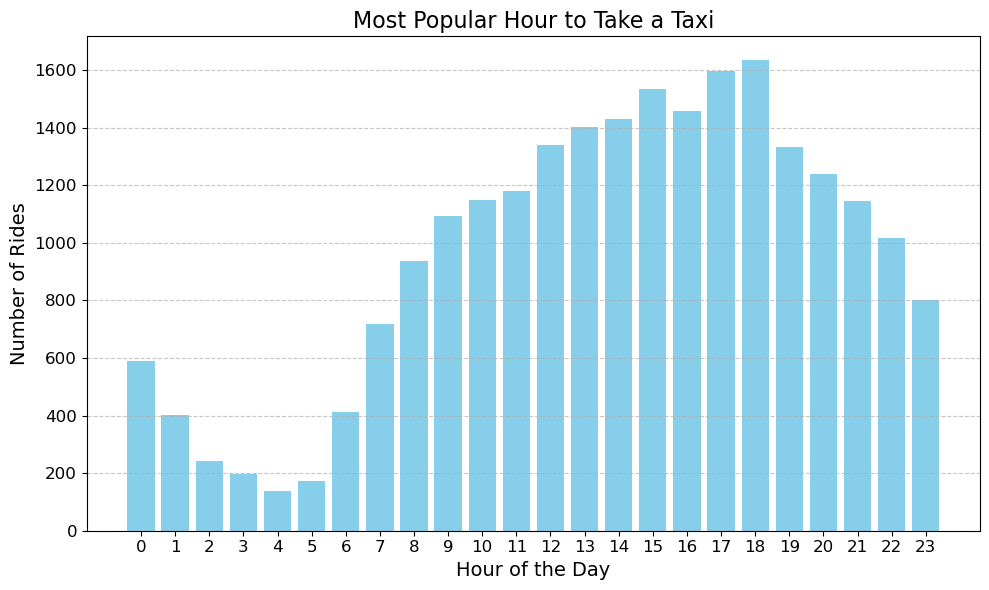

In [74]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_popular_hour(data_file: str, output_image: str = None) -> None:
    """
    Generates a bar chart of the most popular hours to take a taxi.

    """
    try:
        # Load the data
        print(f"Loading data from {data_file}...")
        query1_result = pd.read_csv(data_file)

        # Validate necessary columns
        required_columns = {"hour", "ride_count"}
        if not required_columns.issubset(query1_result.columns):
            raise ValueError(f"Missing required columns in {data_file}: {required_columns}")

        # Plot setup
        print("Generating bar chart...")
        plt.figure(figsize=(10, 6))
        plt.bar(query1_result['hour'], query1_result['ride_count'], color='skyblue')

        # Configure axis and title
        plt.xlabel("Hour of the Day", fontsize=14)
        plt.ylabel("Number of Rides", fontsize=14)
        plt.title("Most Popular Hour to Take a Taxi", fontsize=16)
        plt.xticks(range(0, 24), fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save or display the plot
        if output_image:
            plt.savefig(output_image, format='png', dpi=300)
            print(f"Plot saved as {output_image}")
        else:
            plt.show()

    except Exception as e:
        print(f"An error occurred while plotting data: {e}")


if __name__ == "__main__":
    # File path for query results
    data_file = "results/popular_hour_taxi.csv"

    # Optional: Path to save the plot
    output_image = "results/popular_hour_taxi.png"

    # Generate the plot
    plot_popular_hour(data_file, output_image)


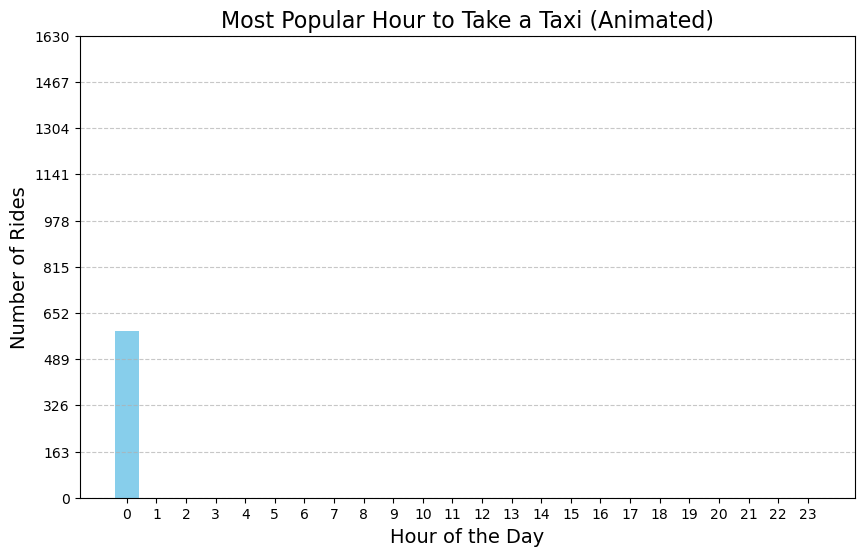

In [59]:
## Extra Credit
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load the results from the query
query1_result = pd.read_csv("results/popular_hour_taxi.csv")

# Ensure the data is sorted by hour
query1_result['hour'] = query1_result['hour'].astype(int)
query1_result = query1_result.sort_values('hour')

# Setup the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(query1_result['hour'], [0] * len(query1_result['hour']), color='skyblue')

# Configure axis labels and title
ax.set_xlabel("Hour of the Day", fontsize=14)
ax.set_ylabel("Number of Rides", fontsize=14)
ax.set_title("Most Popular Hour to Take a Taxi (Animated)", fontsize=16)
ax.set_xticks(range(0, 24))
ax.set_yticks(
    range(0, query1_result['ride_count'].max() + 1, 
          max(1, query1_result['ride_count'].max() // 10))
)
ax.grid(axis='y', linestyle='--', alpha=0.7)

def animate(frame):
    """
    Animation function to update bar heights for each frame.

    Args:
        frame (int): The current frame
    """
    for i, bar in enumerate(bars):
        if i <= frame:
            bar.set_height(query1_result.iloc[i]['ride_count'])
        else:
            bar.set_height(0)
    return bars

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(query1_result), interval=500, repeat=False)

# Render animation in JupyterLab
HTML(ani.to_jshtml())


### Visualization 2: What’s the most popular month to hire a cab or Uber?

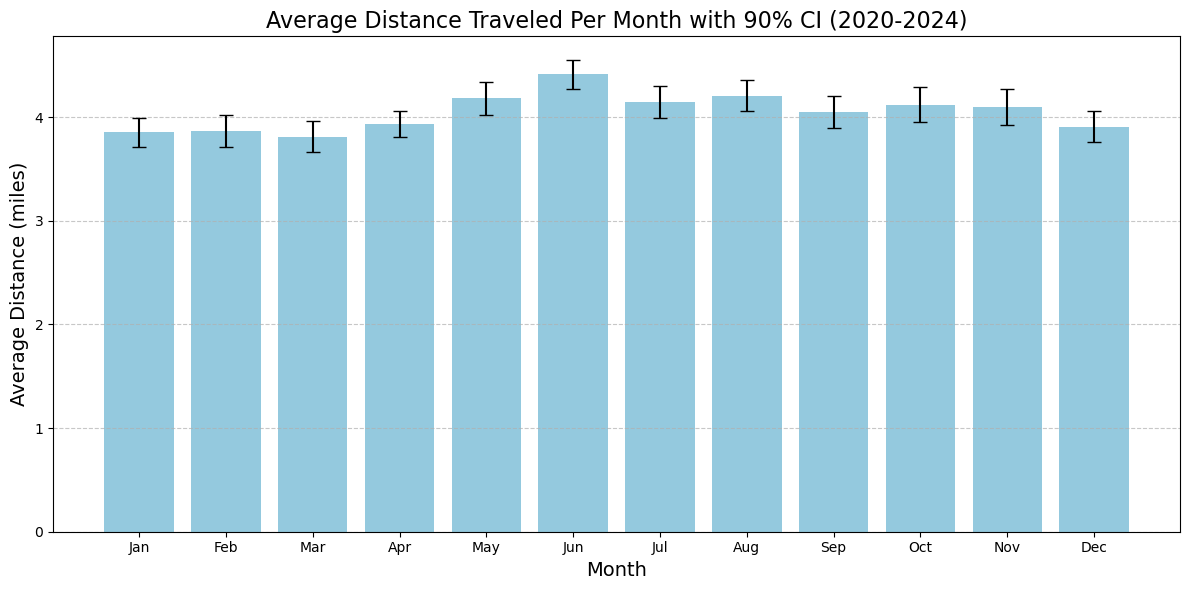

In [71]:
import seaborn as sns
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Connect to the database
conn = sqlite3.connect("project.db")

# Query to extract month and trip_distance from both yellow_taxi and hvfhv
combined_data = pd.read_sql_query("""
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        trip_distance
    FROM yellow_taxi
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        trip_distance
    FROM hvfhv
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
""", conn)

# Calculate average distance and 90% confidence interval
monthly_stats = (
    combined_data.groupby("month")["trip_distance"]
    .agg(mean="mean", std="std", count="size")
    .reset_index()
)
monthly_stats["sem"] = monthly_stats["std"] / monthly_stats["count"] ** 0.5
monthly_stats["ci90"] = 1.645 * monthly_stats["sem"]  # For 90% CI

# Convert month numbers to labels and define their order
monthly_stats["month"] = monthly_stats["month"].astype(int).map({
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
})

monthly_stats["month"] = pd.Categorical(
    monthly_stats["month"],
    categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    ordered=True
)

# Sort by month
monthly_stats = monthly_stats.sort_values("month")

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(
    x="month", 
    y="mean", 
    data=monthly_stats, 
    errorbar=None, 
    color="skyblue"
)
plt.errorbar(
    monthly_stats["month"], 
    monthly_stats["mean"], 
    yerr=monthly_stats["ci90"], 
    fmt="none", 
    capsize=5, 
    color="black"
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Average Distance (miles)", fontsize=14)
plt.title("Average Distance Traveled Per Month with 90% CI (2020-2024)", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Visualization 3: Which day of the week is most popular for rides to airports?

Connecting to database: trips_data.db
Querying ride counts for each airport...
Data retrieval successful.
Processing airport data for visualization...
Airport data processing complete.
Generating plot...


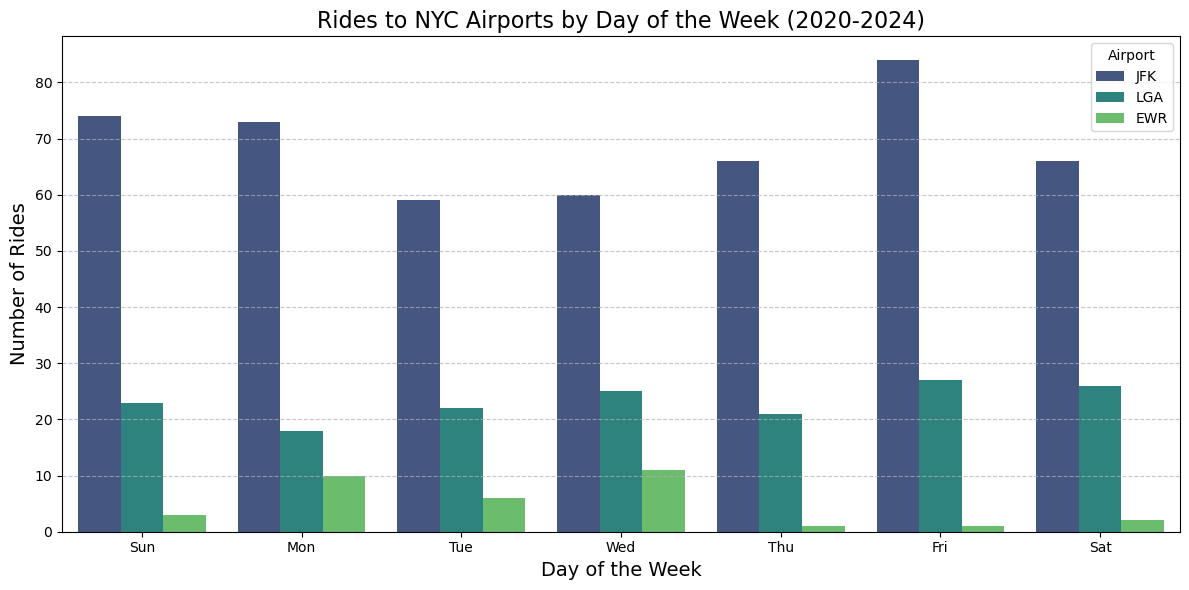

Plot generated successfully.


In [76]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_airport_data(db_name: str, airport_mappings: dict) -> pd.DataFrame:
    """
    Queries the database to retrieve ride counts to NYC airports by day of the week.

    Args:
        db_name (str): The name of the SQLite database file.
        airport_mappings (dict): A dictionary where keys are airport names and values are lists of DOLocationIDs.

    """
    try:
        print(f"Connecting to database: {db_name}")
        conn = sqlite3.connect(db_name)
        airport_data = pd.DataFrame()

        print("Querying ride counts for each airport...")
        for airport, location_ids in airport_mappings.items():
            for location_id in location_ids:
                query = f"""
                SELECT
                    strftime('%w', pickup_datetime) AS day_of_week,
                    COUNT(*) AS ride_count
                FROM (
                    SELECT pickup_datetime FROM yellow_taxi WHERE DOLocationID = {location_id}
                    UNION ALL
                    SELECT pickup_datetime FROM hvfhv WHERE DOLocationID = {location_id}
                )
                GROUP BY day_of_week
                """
                temp_data = pd.read_sql_query(query, conn)
                temp_data["airport"] = airport
                airport_data = pd.concat([airport_data, temp_data], ignore_index=True)

        print("Data retrieval successful.")
        return airport_data

    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return pd.DataFrame()

    finally:
        conn.close()


def preprocess_airport_data(airport_data: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the retrieved airport ride data for visualization.

    Args:
        airport_data (pd.DataFrame): Containing raw airport ride data
    """
    try:
        print("Processing airport data for visualization...")

        # Convert `day_of_week` numbers to labels
        day_mapping = {
            "0": "Sun", "1": "Mon", "2": "Tue", "3": "Wed", "4": "Thu", "5": "Fri", "6": "Sat"
        }
        airport_data["day_of_week"] = airport_data["day_of_week"].map(day_mapping)

        # Aggregate counts for plotting
        airport_stats = airport_data.groupby(["airport", "day_of_week"], as_index=False).sum()

        # Ensure days of the week are ordered correctly
        airport_stats["day_of_week"] = pd.Categorical(
            airport_stats["day_of_week"],
            categories=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
            ordered=True
        )
        airport_stats = airport_stats.sort_values("day_of_week")

        print("Airport data processing complete.")
        return airport_stats

    except Exception as e:
        print(f"An error occurred while processing the airport data: {e}")
        return pd.DataFrame()


def plot_airport_stats(airport_stats: pd.DataFrame) -> None:
    """
    Plots the ride counts to NYC airports by day of the week.

    Args:
        airport_stats (pd.DataFrame): A DataFrame containing aggregated ride counts.
    """
    try:
        print("Generating plot...")
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=airport_stats,
            x="day_of_week",
            y="ride_count",
            hue="airport",
            palette="viridis"
        )
        plt.xlabel("Day of the Week", fontsize=14)
        plt.ylabel("Number of Rides", fontsize=14)
        plt.title("Rides to NYC Airports by Day of the Week (2020-2024)", fontsize=16)
        plt.legend(title="Airport")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")

    except Exception as e:
        print(f"An error occurred while generating the plot: {e}")


if __name__ == "__main__":
    # Database file
    db_name = "trips_data.db"

    # Define airport mappings (Replace with actual DOLocationIDs)
    airport_mappings = {
        "LGA": [1],    # Replace with actual DOLocationID for LGA
        "JFK": [132],  # Replace with actual DOLocationID for JFK
        "EWR": [3]     # Replace with actual DOLocationID for EWR
    }

    # Retrieve, process, and plot data
    raw_airport_data = get_airport_data(db_name, airport_mappings)
    if not raw_airport_data.empty:
        processed_airport_stats = preprocess_airport_data(raw_airport_data)
        if not processed_airport_stats.empty:
            plot_airport_stats(processed_airport_stats)
        else:
            print("No data available for plotting.")
    else:
        print("No data retrieved from the database.")
